In [ ]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 5.0 MB/s 


IMPORTS

In [ ]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, top_k_accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, top_k_accuracy_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import permutation_importance
import shap
from sklearn.metrics import f1_score

pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.pipeline import Pipeline

ATTENTION METRIC

In [ ]:
df_og=pd.read_excel('sample_data/db_neuro_figc (1) (1).xlsx',sheet_name='Sheet3')
df=df_og.drop(['USER ID','TARGET','GRUPPO','Video'],axis=1)
df=df.drop(150,axis=0)

In [ ]:
my_cols=df.drop(['Attenzione','y','Picchi','att-1','att-2','att-3','HRV-1','HRV-2','HRV-3','SCL-1','SCL-2','SCL-3','HR-1','HR-2','HR-3','y_hrv','y_SCL'],axis=1).columns

In [ ]:
import random
def cross_validation_split(dataset, folds):
        dataset_split = []
        df_copy = dataset
        fold_size = int(df_copy.shape[0] / folds)
        
        # for loop to save each fold
        for i in range(folds):
            fold = []
            # while loop to add elements to the folds
            while len(fold) < fold_size:
                # select a random element
                r = random.randrange(df_copy.shape[0])
                # determine the index of this element 
                index = df_copy.index[r]
                # save the randomly selected line 
                fold.append(df_copy.loc[index].values.tolist())
                # delete the randomly selected line from
                # dataframe not to select again
                df_copy = df_copy.drop(index)
            # save the fold     
            dataset_split.append(np.asarray(fold))
            
        return dataset_split

AVERAGE AUC:  0.6922645687645688
AVERAGE ACC:  0.78
AVERAGE LIFT:  0.7928571428571429
AVERAGE F1: 0.7614200598113643


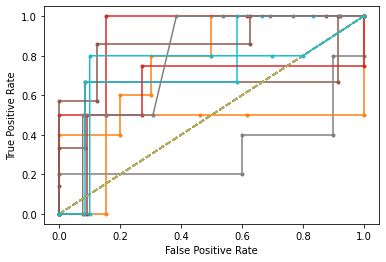

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import SGDClassifier

x_cv=df.drop(['Attenzione','y','Picchi','att-1','att-2','att-3','y_SCL','y_hrv'],axis=1)
cols=x_cv.columns
x_cv = StandardScaler().fit_transform(x_cv)
x_cv=pd.DataFrame(x_cv)
x_cv.columns=cols
x_cv['Picchi']=df['Picchi']

folds=10
data=cross_validation_split(x_cv,folds)

auc_clf=np.array([])
acc_clf=np.array([])
lift_clf=np.array([])
f1_clf=np.array([])
for i in range(1):
  for i in range(folds):

    X_test=data[i][:,:-1]
    y_test=data[i][:,-1]
    train=np.zeros(data[i].shape)
    for f in range(folds):
      if f!=i:
        train=np.concatenate((train,data[f]), axis=0)
      else:
        continue
    t=pd.DataFrame(train)
    t=t.iloc[data[i].shape[0]:]
    X_train=t.iloc[:,:-1]
    y_train=t.iloc[:,-1]

    #MODEL START
    model = RandomForestClassifier(random_state=0)
    model.fit(X_train,y_train)
    lr_probs = model.predict_proba(X_test)
    y_hat=model.predict(X_test)
    acc_score=np.sum(y_hat==y_test)/len(y_test)
    acc_clf=np.append(acc_clf,acc_score)

    ones_pred_ratio=y_hat.sum()/len(y_hat)
    ones_average_ratio=y_test.sum()/len(y_test)
    lift_score=ones_pred_ratio/ones_average_ratio
    if ones_average_ratio==0 and ones_pred_ratio==0 :
      pass
    else:
      lift_clf=np.append(lift_clf,lift_score)

    #AUC AND ROC
    try:
      ns_probs = [0 for _ in range(len(y_test))]
      lr_probs = lr_probs[:, 1]
      ns_auc = roc_auc_score(y_test, ns_probs)
      lr_auc = roc_auc_score(y_test, lr_probs)
      auc_clf=np.append(auc_clf,lr_auc)
    except:
      continue
    lr_f1=f1_score(y_test, y_hat, average='weighted')
    f1_clf=np.append(f1_clf,lr_f1)

    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='CLF')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

print('AVERAGE AUC: ', np.mean(auc_clf))
print('AVERAGE ACC: ', np.mean(acc_clf))
print('AVERAGE LIFT: ', np.mean(lift_clf))
print('AVERAGE F1:',np.mean(f1_clf))

FEATURES IMPACT VISUALIZATION

In [ ]:
model

RandomForestClassifier(random_state=0)

Text(0.5, 0, 'Random Forest Feature Importance')

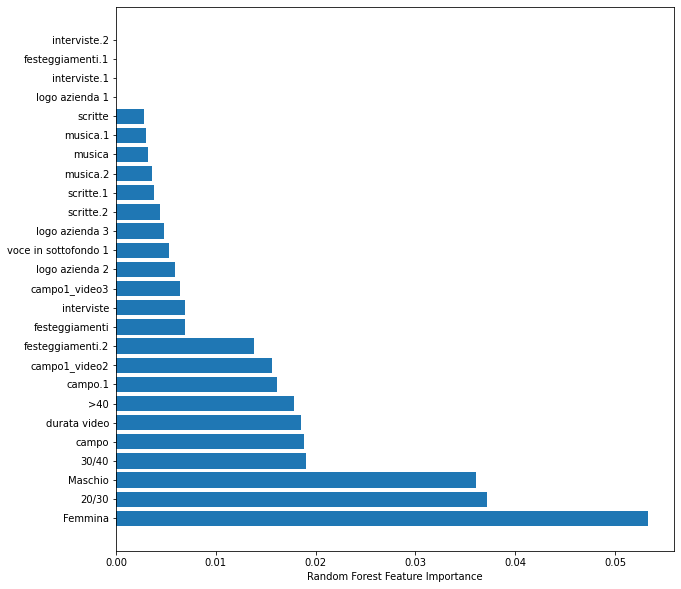

In [ ]:
sorted_idx = model.feature_importances_.argsort()
sorted_idx=sorted_idx[::-1]

mask=[]
for m in x_cv.columns[sorted_idx]:
  if m in my_cols:
    mask.append(m)
  
h=pd.DataFrame(model.feature_importances_).T
h.columns=x_cv.columns[:-1]
h=h[mask]

sorted_idx = model.feature_importances_.argsort()
sorted_idx=sorted_idx[::-1]
plt.figure(figsize=(10, 10))
plt.barh(h.columns, h.values[0])
plt.xlabel("Random Forest Feature Importance")

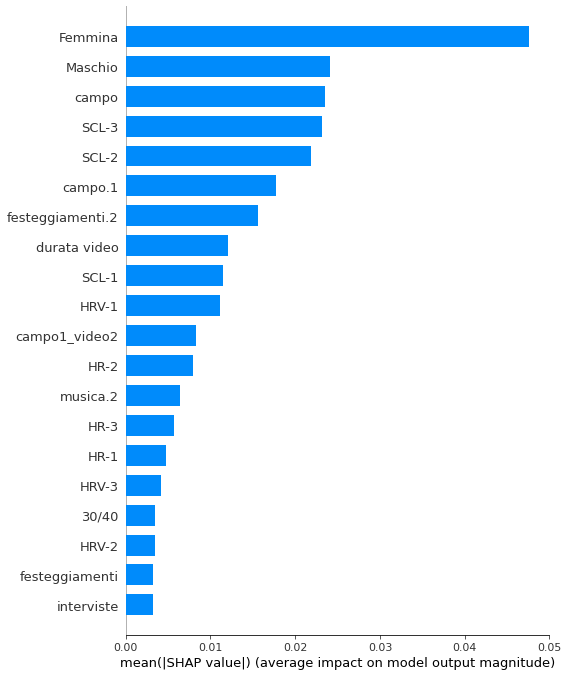

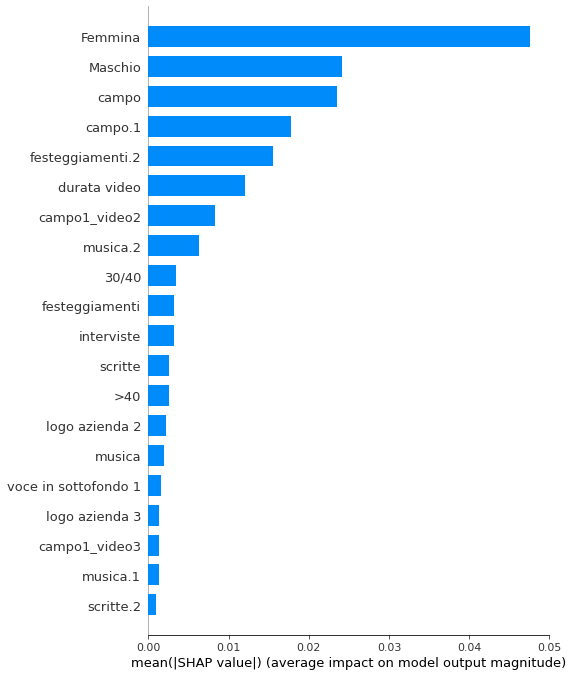

In [ ]:
S = pd.DataFrame(X_test).copy(deep=True)
S=pd.DataFrame(S)
S.columns=x_cv.columns[:-1]

explainer =shap.Explainer(model.predict, S)
shap_value =explainer(S)
shap_values=shap_value.values
hh=pd.DataFrame(shap_values)
hh.columns=S.columns

shap.summary_plot(hh.values, S,feature_names=S.columns,plot_type='bar')
shap.summary_plot(hh[my_cols].values, S[my_cols],feature_names=my_cols,plot_type='bar')

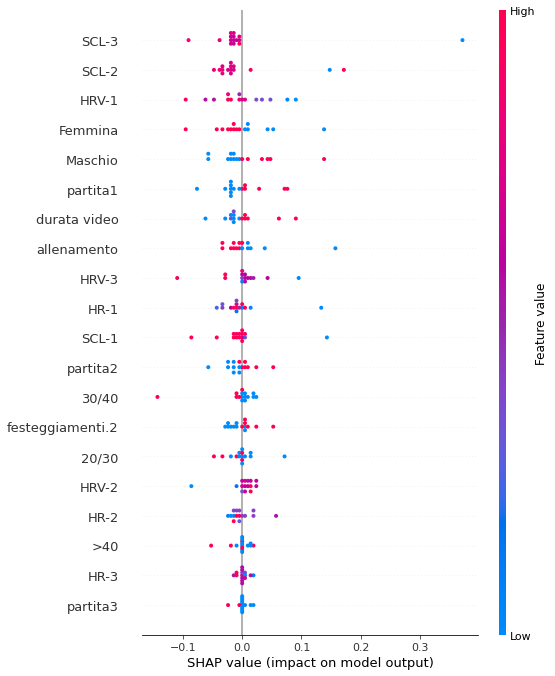

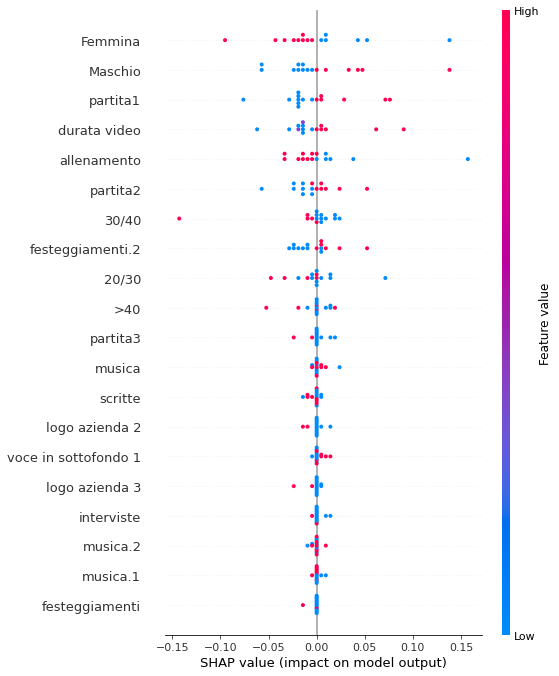

In [ ]:
S = pd.DataFrame(X_test).copy(deep=True)
S=pd.DataFrame(S)
S.columns=x_cv.columns[:-1]

explainer =shap.Explainer(model.predict, S)
shap_value =explainer(S)
shap_values=shap_value.values
hh=pd.DataFrame(shap_values)
hh.columns=S.columns

shap.summary_plot(hh.values, S,feature_names=S.columns)
shap.summary_plot(hh[my_cols].values, S[my_cols],feature_names=my_cols)

**HEART RATE VARIATION METRIC**

In [ ]:
df_og=pd.read_excel('sample_data/db_neuro_figc (1) (1).xlsx',sheet_name='Sheet3')
df=df_og.drop(['USER ID','TARGET','GRUPPO','Video'],axis=1)
df=df.drop(150,axis=0)

AVERAGE AUC:  0.4522854367854368
AVERAGE ACC:  0.7133333333333333
AVERAGE LIFT:  0.1325
AVERAGE F1: 0.6274971159109088


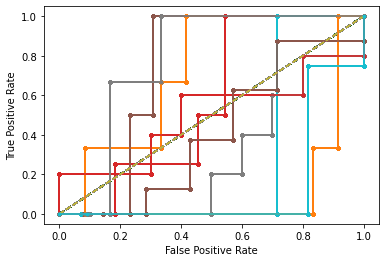

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import SGDClassifier

x_cv=df.drop(['Attenzione','y','Picchi','HRV-1','HRV-2','HRV-3','y_SCL','y_hrv'],axis=1)
cols=x_cv.columns
x_cv = StandardScaler().fit_transform(x_cv)
x_cv=pd.DataFrame(x_cv)
x_cv.columns=cols
x_cv['y_hrv']=df['y_hrv']


folds=10
data=cross_validation_split(x_cv,folds)

auc_clf=np.array([])
acc_clf=np.array([])
lift_clf=np.array([])
f1_clf=np.array([])
for i in range(100):
  for i in range(folds):

    X_test=data[i][:,:-1]
    y_test=data[i][:,-1]
    train=np.zeros(data[i].shape)
    for f in range(folds):
      if f!=i:
        train=np.concatenate((train,data[f]), axis=0)
      else:
        continue
    t=pd.DataFrame(train)
    t=t.iloc[data[i].shape[0]:]
    X_train=t.iloc[:,:-1]
    y_train=t.iloc[:,-1]


    model=RandomForestClassifier(random_state=0)
    model.fit(X_train,y_train)
    lr_probs = model.predict_proba(X_test)
    y_hat=model.predict(X_test)
    acc_score=np.sum(y_hat==y_test)/len(y_test)
    acc_clf=np.append(acc_clf,acc_score)

    ones_pred_ratio=y_hat.sum()/len(y_hat)
    ones_average_ratio=y_test.sum()/len(y_test)
    lift_score=ones_pred_ratio/ones_average_ratio
    if ones_average_ratio==0 and ones_pred_ratio==0 :
      pass
    else:
      lift_clf=np.append(lift_clf,lift_score)

    #AUC E ROC
    try:
      ns_probs = [0 for _ in range(len(y_test))]
      lr_probs = lr_probs[:, 1]
      ns_auc = roc_auc_score(y_test, ns_probs)
      lr_auc = roc_auc_score(y_test, lr_probs)
      auc_clf=np.append(auc_clf,lr_auc)
    except:
      continue

    lr_f1=f1_score(y_test, y_hat, average='weighted')
    f1_clf=np.append(f1_clf,lr_f1)


    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='CLF')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

print('AVERAGE AUC: ', np.mean(auc_clf))
print('AVERAGE ACC: ', np.mean(acc_clf))
print('AVERAGE LIFT: ', np.mean(lift_clf))
print('AVERAGE F1:',np.mean(f1_clf))

FEATURES IMPACT VISUALIZATION

In [ ]:
model

RandomForestClassifier(random_state=0)

Text(0.5, 0, 'Random Forest Feature Importance')

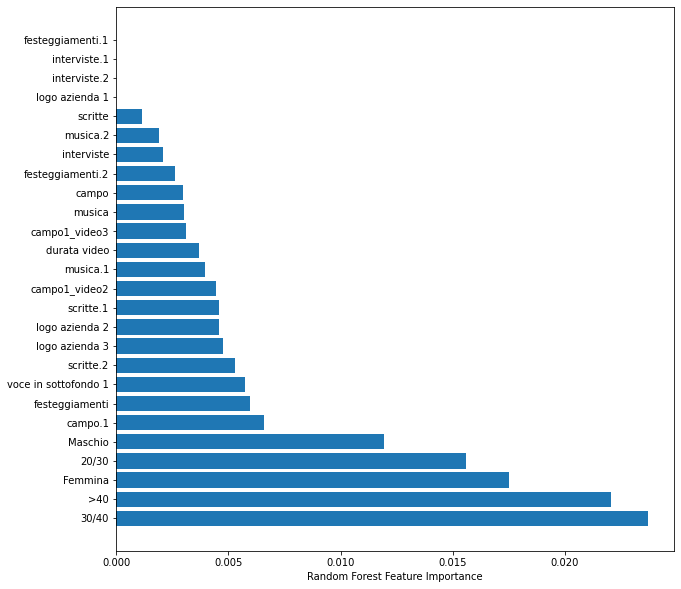

In [ ]:
sorted_idx = model.feature_importances_.argsort()
sorted_idx=sorted_idx[::-1]

mask=[]
for m in x_cv.columns[sorted_idx]:
  if m in my_cols:
    mask.append(m)
  
h=pd.DataFrame(model.feature_importances_).T
h.columns=x_cv.columns[:-1]
h=h[mask]

sorted_idx = model.feature_importances_.argsort()
sorted_idx=sorted_idx[::-1]
plt.figure(figsize=(10, 10))
plt.barh(h.columns, h.values[0])
plt.xlabel("Random Forest Feature Importance")

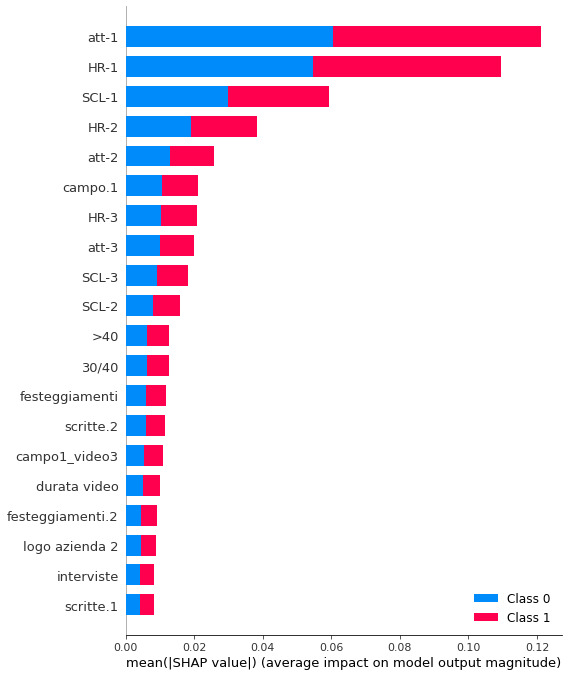

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test,feature_names=x_cv.columns[:-1],plot_type='bar')

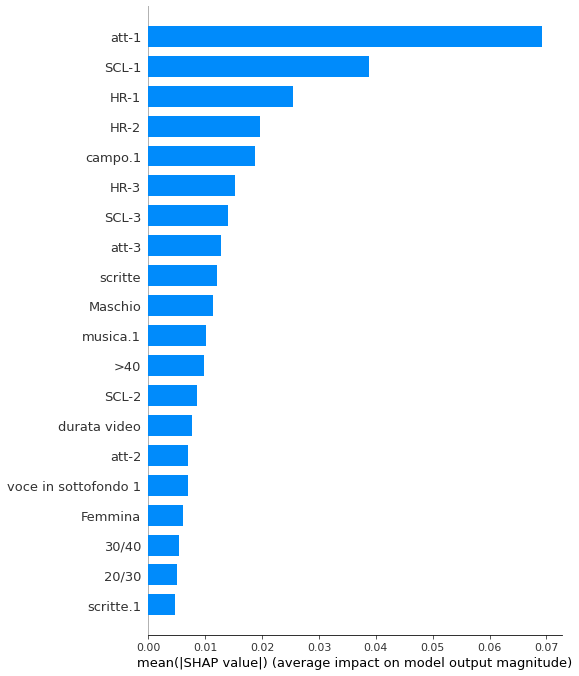

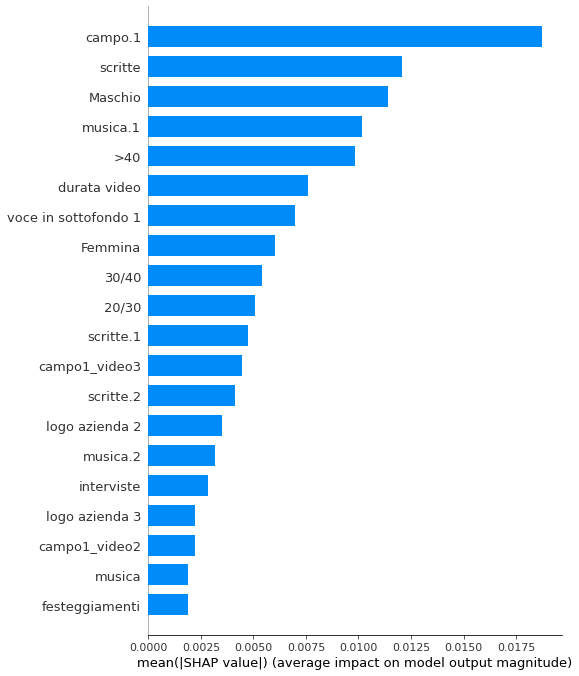

In [ ]:
#full
S = pd.DataFrame(X_test).copy(deep=True)
S=pd.DataFrame(S)
S.columns=x_cv.columns[:-1]

explainer =shap.Explainer(model.predict, S)
shap_value =explainer(S)
shap_values=shap_value.values
hh=pd.DataFrame(shap_values)
hh.columns=S.columns

shap.summary_plot(hh.values, S,feature_names=S.columns,plot_type='bar')
shap.summary_plot(hh[my_cols].values, S[my_cols],feature_names=my_cols,plot_type='bar')

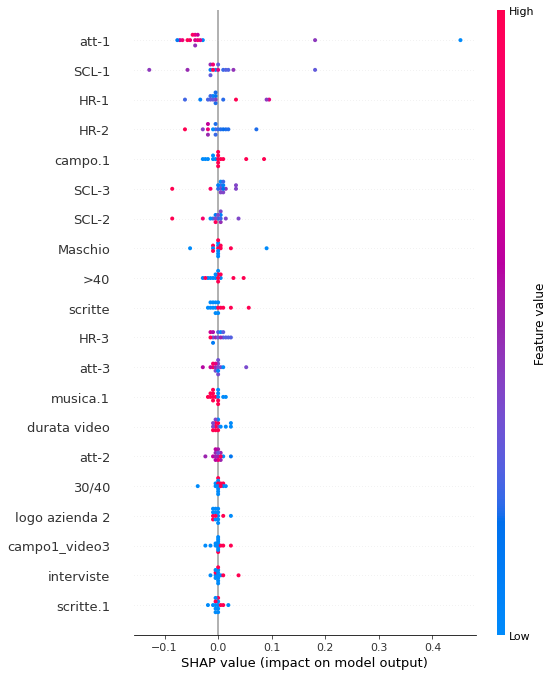

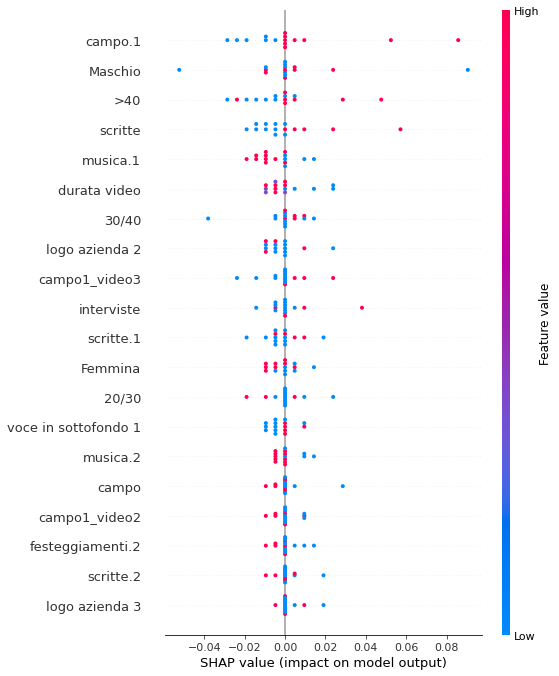

In [ ]:
S = pd.DataFrame(X_test).copy(deep=True)
S=pd.DataFrame(S)
S.columns=x_cv.columns[:-1]

explainer =shap.Explainer(model.predict, S)
shap_value =explainer(S)
shap_values=shap_value.values
hh=pd.DataFrame(shap_values)
hh.columns=S.columns

shap.summary_plot(hh.values, S,feature_names=S.columns)

shap.summary_plot(hh[my_cols].values, S[my_cols],feature_names=my_cols)

SKIN CONDUCTANCE LEVEL METRIC


In [ ]:
df_og=pd.read_excel('sample_data/db_neuro_figc (1) (1).xlsx',sheet_name='Sheet3')
df=df_og.drop(['USER ID','TARGET','GRUPPO','Video'],axis=1)
df=df.drop(150,axis=0)

AVERAGE AUC:  0.6125601250601249
AVERAGE ACC:  0.74
AVERAGE LIFT:  0.28928571428571426
AVERAGE F1: 0.6831026540120994


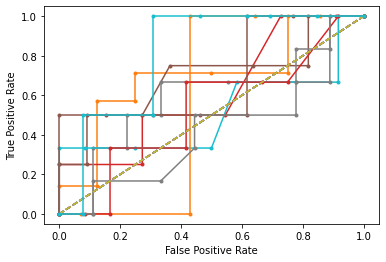

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import SGDClassifier

#CHECK
x_cv=df.drop(['Attenzione','y','Picchi','SCL-1','SCL-2','SCL-3','y_SCL','y_hrv'],axis=1)
cols=x_cv.columns
x_cv = StandardScaler().fit_transform(x_cv)
x_cv=pd.DataFrame(x_cv)
x_cv.columns=cols
x_cv['y_SCL']=df['y_SCL']


folds=10
data=cross_validation_split(x_cv,folds)

auc_clf=np.array([])
acc_clf=np.array([])
lift_clf=np.array([])
f1_clf=np.array([])
for i in range(1):
  for i in range(folds):

    X_test=data[i][:,:-1]
    y_test=data[i][:,-1]
    train=np.zeros(data[i].shape)
    for f in range(folds):
      if f!=i:
        train=np.concatenate((train,data[f]), axis=0)
      else:
        continue
    t=pd.DataFrame(train)
    t=t.iloc[data[i].shape[0]:]
    X_train=t.iloc[:,:-1]
    y_train=t.iloc[:,-1]


    #MODELLO INIZIA QUI
    model = RandomForestClassifier(random_state=0)
    model.fit(X_train,y_train)
    lr_probs = model.predict_proba(X_test)
    y_hat=model.predict(X_test)
    acc_score=np.sum(y_hat==y_test)/len(y_test)
    acc_clf=np.append(acc_clf,acc_score)

    ones_pred_ratio=y_hat.sum()/len(y_hat)
    ones_average_ratio=y_test.sum()/len(y_test)
    lift_score=ones_pred_ratio/ones_average_ratio
    if ones_average_ratio==0 and ones_pred_ratio==0 :
      pass
    else:
      lift_clf=np.append(lift_clf,lift_score)

    #AUC E ROC
    try:
      ns_probs = [0 for _ in range(len(y_test))]
      lr_probs = lr_probs[:, 1]
      ns_auc = roc_auc_score(y_test, ns_probs)
      lr_auc = roc_auc_score(y_test, lr_probs)
      auc_clf=np.append(auc_clf,lr_auc)
    except:
      continue

    lr_f1=f1_score(y_test, y_hat, average='weighted')
    f1_clf=np.append(f1_clf,lr_f1)

    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='CLF')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')


print('AVERAGE AUC: ', np.mean(auc_clf))
print('AVERAGE ACC: ', np.mean(acc_clf))
print('AVERAGE LIFT: ', np.mean(lift_clf))
print('AVERAGE F1:',np.mean(f1_clf))

FEATURE IMPACT VISUALIZATION

In [ ]:
model

RandomForestClassifier(random_state=0)

Text(0.5, 0, 'Random Forest Feature Importance')

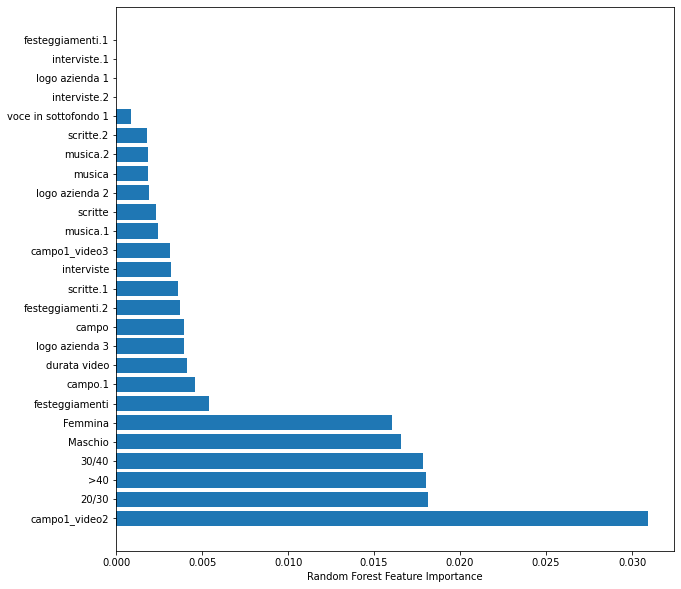

In [ ]:
sorted_idx = model.feature_importances_.argsort()
sorted_idx=sorted_idx[::-1]

mask=[]
for m in x_cv.columns[sorted_idx]:
  if m in my_cols:
    mask.append(m)
  
h=pd.DataFrame(model.feature_importances_).T
h.columns=x_cv.columns[:-1]
h=h[mask]

sorted_idx = model.feature_importances_.argsort()
sorted_idx=sorted_idx[::-1]
plt.figure(figsize=(10, 10))
plt.barh(h.columns, h.values[0])
plt.xlabel("Random Forest Feature Importance")

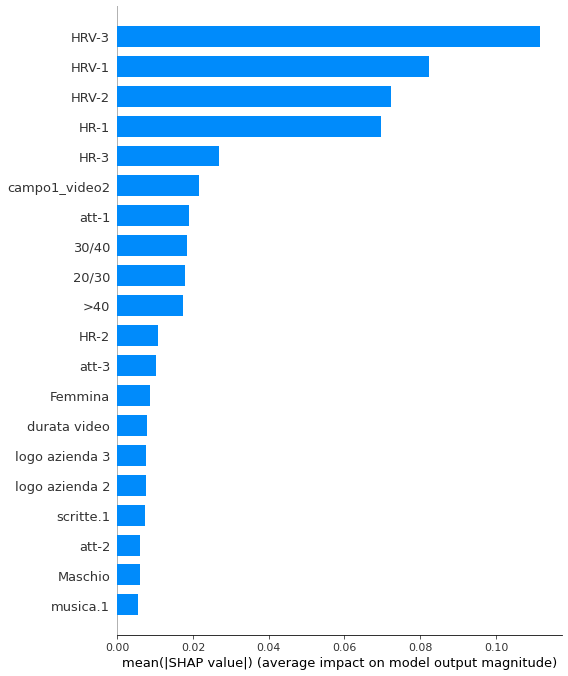

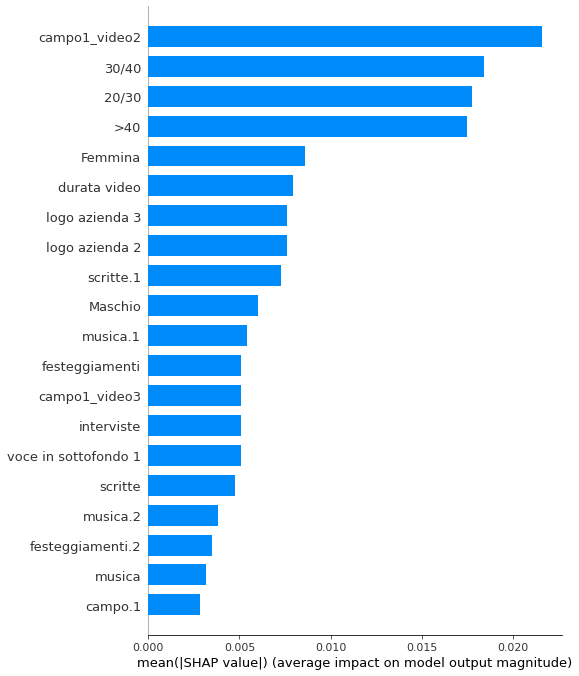

In [ ]:
#full
S = pd.DataFrame(X_test).copy(deep=True)
S=pd.DataFrame(S)
S.columns=x_cv.columns[:-1]

explainer =shap.Explainer(model.predict, S)
shap_value =explainer(S)
shap_values=shap_value.values
hh=pd.DataFrame(shap_values)
hh.columns=S.columns

shap.summary_plot(hh.values, S,feature_names=S.columns,plot_type='bar')
shap.summary_plot(hh[my_cols].values, S[my_cols],feature_names=my_cols,plot_type='bar')

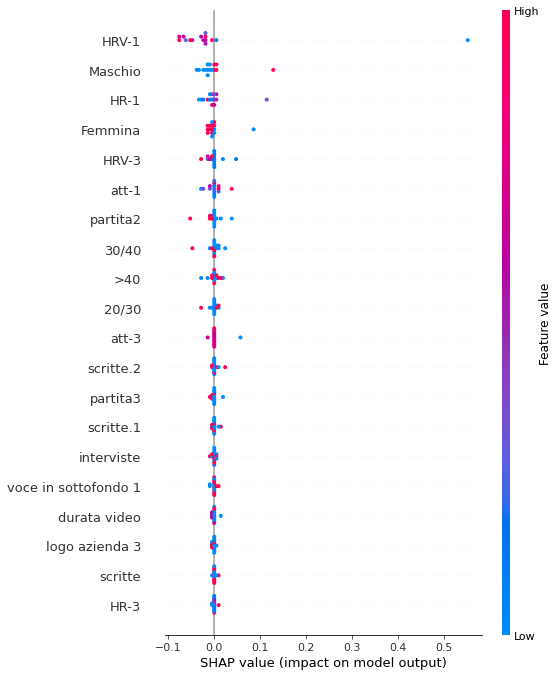

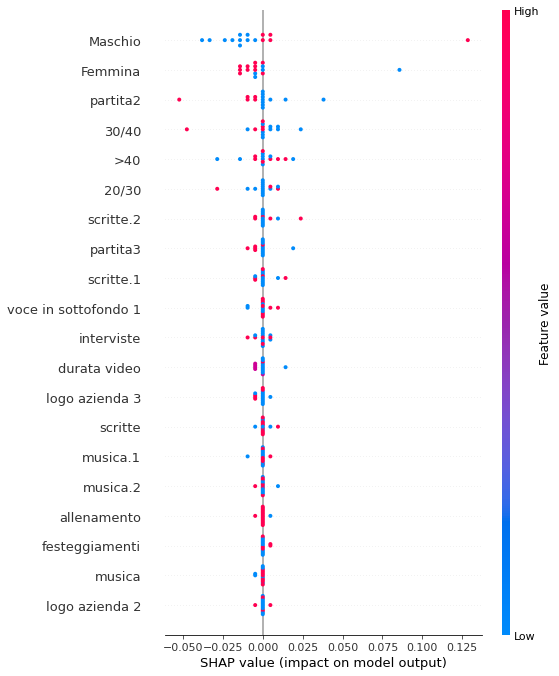

In [ ]:
S = pd.DataFrame(X_test).copy(deep=True)
S=pd.DataFrame(S)
S.columns=x_cv.columns[:-1]

explainer =shap.Explainer(model.predict, S)
shap_value =explainer(S)
shap_values=shap_value.values
hh=pd.DataFrame(shap_values)
hh.columns=S.columns

shap.summary_plot(hh.values, S,feature_names=S.columns)

shap.summary_plot(hh[my_cols].values, S[my_cols],feature_names=my_cols)